In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data as web
import matplotlib.pyplot as plt
import seaborn as sns

/Users/berkatbhatti/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
data = pd.DataFrame(web.DataReader("UVXY", data_source="yahoo", start= "2017-1-1")["Adj Close"])

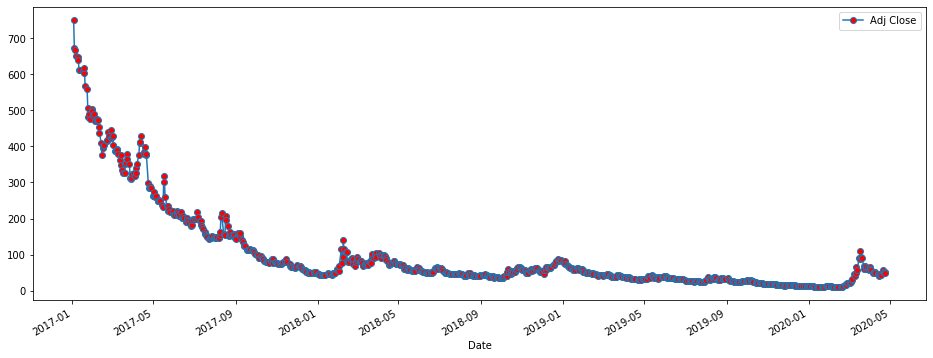

In [3]:
data.plot(figsize = (16,6), marker = "o", mfc = "r");

## Spliting
- we will take 30days of the data as our training set..

In [4]:
test_percent = 0.1
sizz = np.round(len(data) * test_percent)
sizz

83.0

In [5]:
test_index = int(len(data) - sizz)

In [6]:
test_index

750

In [7]:
len(data)

833

## Training

In [8]:
train = data.iloc[:test_index]

In [9]:
test = data.iloc[test_index:]

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 750 entries, 2017-01-03 to 2019-12-24
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  750 non-null    float64
dtypes: float64(1)
memory usage: 11.7 KB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83 entries, 2019-12-26 to 2020-04-24
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  83 non-null     float64
dtypes: float64(1)
memory usage: 1.3 KB


### Scaling the data

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scalar = MinMaxScaler()

In [14]:
train_scaled = scalar.fit_transform(train)

In [15]:
test_scaled = scalar.transform(test)

## Plots

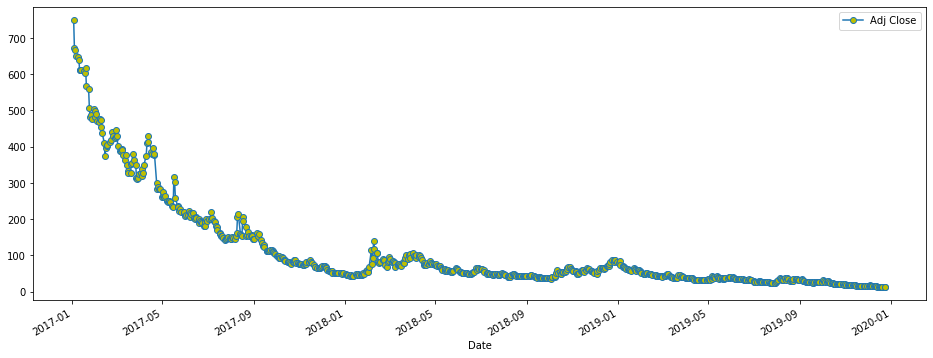

In [16]:
train.plot(figsize = (16,6), marker = "o", mfc = "y")

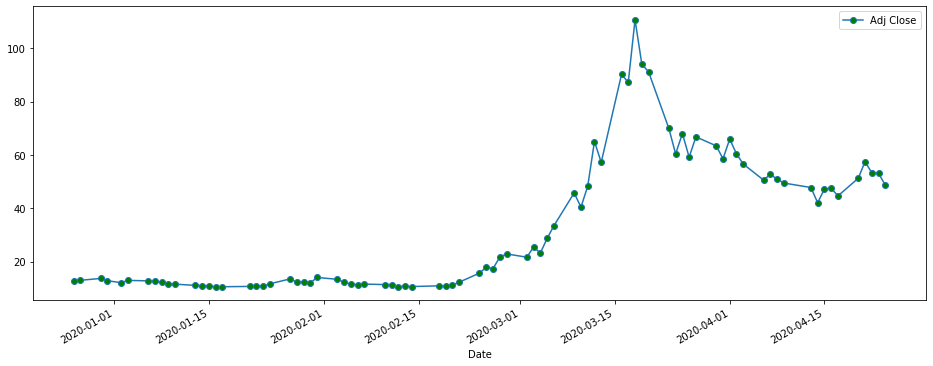

In [17]:
test.plot(figsize = (16,6), marker = "o", mfc = "g")

### Batches with time series Generator

In [18]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [19]:
length = 10
generator = TimeseriesGenerator(train_scaled,train_scaled, batch_size=1,length= length)

## Reviewing Generator
- Generator is proving to be structured correctly for the y value at position 30 is accurate

In [20]:
X,y = generator[0]

In [21]:
X

array([[[1.        ],
        [0.89558189],
        [0.8888015 ],
        [0.86574815],
        [0.86167991],
        [0.84811912],
        [0.81286106],
        [0.81069136],
        [0.81367467],
        [0.80743674]]])

In [22]:
y

array([[0.80174119]])

In [23]:
train_scaled[80:91]

array([[0.36752462],
       [0.3382333 ],
       [0.3401318 ],
       [0.35423502],
       [0.33606356],
       [0.33958938],
       [0.32168914],
       [0.32006185],
       [0.32223156],
       [0.32033306],
       [0.3195194 ]])

### Model Creation

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN, LSTM

In [25]:
n_features = 1

In [26]:
model = Sequential()
model.add(LSTM(units = 30, activation = "relu", input_shape = (length, n_features)))
model.add(Dense(units = 1))
model.compile(optimization = "adam", loss = "mse")

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30)                3840      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


### Earlly Stopping:
- Since RNN takes time to train we can set our Epoch value and let tensorFLow deside to stop training when the loss value is low enough and break when the model begins to overtrain

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
early = EarlyStopping(monitor= "val_loss", patience=2)

### Vaidation generator
-- Since we are fitting to a generator our validation data must come from a generator and out validation data will come from our scaled test set

In [30]:
validation_g = TimeseriesGenerator(test_scaled,test_scaled,length= length,batch_size=1)

## fitting model

In [31]:
model.fit_generator(generator, validation_data=validation_g, epochs=20, callbacks=[early])

Epoch 1/20
740/740 [==============================] - 258s 349ms/step - loss: 0.0020 - val_loss: 3.8389e-04
Epoch 2/20
740/740 [==============================] - 251s 339ms/step - loss: 5.4010e-04 - val_loss: 7.4465e-04
Epoch 3/20
740/740 [==============================] - 254s 344ms/step - loss: 4.9231e-04 - val_loss: 5.6654e-04


## model performance 

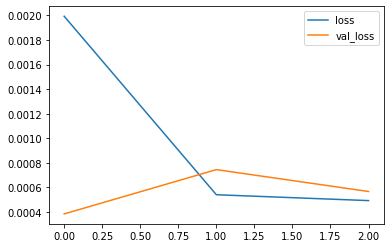

In [32]:
pd.DataFrame(model.history.history).plot()

## Test predictions
- Using our model to make predictions on the Testing data

In [33]:
test_predictions = []
first_batch = train_scaled[-length:]
current_batch = first_batch.reshape((1,length,n_features))

for i in range(len(test)):
    current_prediciton = model.predict(current_batch)[0]
    test_predictions.append(current_prediciton)
    current_batch = np.append(current_batch[:,1:,:], [[current_prediciton]], axis = 1)
    

### inverse Scaling
- WE have to remember out model was trained on scaled data so we need to inverse this process for the true value
- we will then need to match these predicitons up with our original test data

In [36]:
true_predictions = scalar.inverse_transform(test_predictions)

In [38]:
test["predicitons"] = true_predictions

/Users/berkatbhatti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


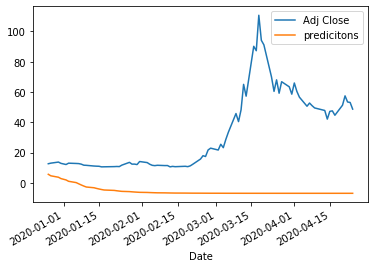

In [40]:
test.plot()